In [1]:
import os
os.getcwd( )

'C:\\Users\\Juan\\skimlit'

In [2]:
os.chdir('D:\\Jupyter projects\\skimlit') 

In [3]:
os.getcwd( )

'D:\\Jupyter projects\\skimlit'

In [4]:
# Check for GPU
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 (UUID: GPU-e8861a5c-89dd-5ee2-06b2-d3bca4ee7bc6)


In [7]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git


Cloning into 'pubmed-rct'...
'ls' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
!dir pubmed-rct

 Volume in drive D is DATA
 Volume Serial Number is B29C-03D0

 Directory of D:\Jupyter projects\skimlit\pubmed-rct

31/10/2022  22:23    <DIR>          .
31/10/2022  22:23    <DIR>          ..
31/10/2022  22:23    <DIR>          PubMed_200k_RCT
31/10/2022  22:23    <DIR>          PubMed_200k_RCT_numbers_replaced_with_at_sign
31/10/2022  22:23    <DIR>          PubMed_20k_RCT
31/10/2022  22:23    <DIR>          PubMed_20k_RCT_numbers_replaced_with_at_sign
31/10/2022  22:23             2,384 README.md
               1 File(s)          2,384 bytes
               6 Dir(s)  409,996,783,616 bytes free


In [10]:
# Check what files are in the PubMed_20K dataset 
!dir pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

Parameter format not correct - "PubMed_20k_RCT_numbers_replaced_with_at_sign".


In [5]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [7]:
# Create function to read the lines of a document
def get_lines(filename):
    """
    Reads filename (a text file) and returns the lines of text as a list.
    
    Args:
        filename: a string containing the target filepath to read.
    
    Returns:
        A list of strings with one string per line from the target filename.
        For example:
        ["this is the first line of filename",
         "this is the second line of filename",
         "..."]
    """
    with open(filename, "r") as f:
        return f.readlines()

In [8]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
def preprocess_text_with_line_numbers(filename):
    """Returns a list of dictionaries of abstract line data.

    Takes in filename, reads its contents and sorts through each line,
    extracting things like the target label, the text of the sentence,
    how many sentences are in the current abstract and what sentence number
    the target line is.

    Args:
        filename: a string of the target text file to read and extract line data
        from.

    Returns:
        A list of dictionaries each containing a line from an abstract,
        the lines label, the lines position in the abstract and the total number
        of lines in the abstract where the line is from. For example:

        [{"target": 'CONCLUSION',
          "text": The study couldn't have gone better, turns out people are kinder than you think",
          "line_number": 8,
          "total_lines": 8}]
    """
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []
    
    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = "" #reset abstract string
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()
            
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")#split target label from text
                line_data["target"] = target_text_split[0] #get target label
                line_data["text"] = target_text_split[1].lower() # get target text and lower it
                line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
                line_data["total_lines"] = len(abstract_line_split) - 1 ## how many total lines are in the abstract? (start from 0)
                abstract_samples.append(line_data) # add line data to abstract samples list
                
        else: #if above conditions arent fulfilled, the line contains the labelled sentence
            abstract_lines += line
            
    return abstract_samples

In [10]:
%%time

train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") #dev=validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

len(train_samples), len(val_samples), len(test_samples)

Wall time: 647 ms


(180040, 30212, 30135)

In [11]:
#check first abstract of training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

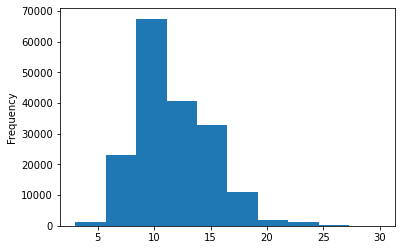

In [14]:
train_df.total_lines.plot.hist()

In [15]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [17]:
#one hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))

#check training labels
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
#Label encode labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

#check training labels
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
#get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#create pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

#fit pipeline to training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
#evaluate baseline on validation set
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [22]:
#make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-11-02 16:53:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py'

     0K ..........                                            100% 3.28M=0.003s

2022-11-02 16:53:20 (3.28 MB/s) - 'helper_functions.py' saved [10246/10246]



In [24]:
from helper_functions import calculate_results

In [25]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
#how long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

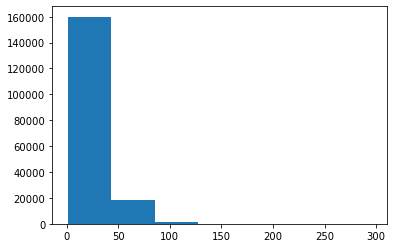

In [29]:
#distribution
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [30]:
#how long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [31]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

And since discovered a sentence length of 55 covers 95% of the training sentences, we'll use that as our output_sequence_length parameter.

In [32]:
#create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, #number of words in vocab
                                    output_sequence_length=55) #desired output length of vectorized sequences

In [33]:
#adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [43]:
#test text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
no deaths occurred .

Length of text: 4

Vectorized text:
[[  33 1254  344    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [44]:
#how many words in our training vocab?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [45]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [46]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128,# Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding"
                              )

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
no deaths occurred .

Sentence after vectorization (before embedding):
[[  33 1254  344    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[ 0.04249867 -0.02054707  0.02040435 ... -0.03401254  0.03974767
    0.00280558]
  [ 0.02417399 -0.04129678 -0.04778774 ...  0.04807645 -0.04934117
    0.01046914]
  [ 0.00529259 -0.04349089  0.04941614 ... -0.00886861  0.0481861
   -0.01885399]
  ...
  [ 0.04702115 -0.02689379 -0.0290525  ...  0.04582962  0.03493682
   -0.00019791]
  [ 0.04702115 -0.02689379 -0.0290525  ...  0.04582962  0.03493682
   -0.00019791]
  [ 0.04702115 -0.02689379 -0.0290525  ...  0.04582962  0.03493682
   -0.00019791]]]

Embedded sentence shape: (1, 55, 128)


In [47]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [48]:
#take TensorSliceDataset and turn them into prefetched batches

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [49]:
#Model 1: Conv1D with token embeddings
# Create 1D convolutional model to process sequences

inputs = layers.Input(shape=(1, ), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embeddings
x = layers.Conv1D(64, kernel_size=5, padding="same", activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) #condense output of feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [50]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [51]:
len(train_dataset)

5627

In [52]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 13s 8ms/step - loss: 0.9203 - accuracy: 0.6393 - val_loss: 0.6842 - val_accuracy: 0.7410
Epoch 2/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6551 - accuracy: 0.7570 - val_loss: 0.6342 - val_accuracy: 0.7736
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6139 - accuracy: 0.7759 - val_loss: 0.5948 - val_accuracy: 0.7869


In [53]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5949 - accuracy: 0.7880


[0.5949373245239258, 0.7879650592803955]

In [54]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[4.6994212e-01, 1.4422594e-01, 5.3681195e-02, 3.0807778e-01,
        2.4072979e-02],
       [4.1728234e-01, 3.0866230e-01, 1.2770690e-02, 2.5216243e-01,
        9.1222413e-03],
       [1.5057959e-01, 5.4801204e-03, 2.1188292e-03, 8.4177375e-01,
        4.7712401e-05],
       ...,
       [1.0408709e-05, 6.5695727e-04, 1.0600114e-03, 4.6237683e-06,
        9.9826801e-01],
       [5.3442825e-02, 4.5694879e-01, 7.5917602e-02, 6.2281877e-02,
        3.5140887e-01],
       [1.7071326e-01, 6.9483531e-01, 4.6577584e-02, 5.5633642e-02,
        3.2240123e-02]], dtype=float32)

In [55]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [56]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds
)

In [57]:
model_1_results

{'accuracy': 78.79650470011916,
 'precision': 0.78526292366117,
 'recall': 0.7879650470011916,
 'f1': 0.7857385360883143}

In [58]:
#Model 2: Feature extraction with pretrained token embeddings
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name='universal_sentence_encoder'
)

In [59]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
to compare the effects of neuromuscular exercise ( nexa ) and quadriceps strengthening ( qs ) on the knee adduction moment ( an indicator of mediolateral distribution of knee load ) , pain , and physical function in patients with medial knee joint osteoarthritis ( oa ) and varus malalignment .

Sentence after embedding:
[ 0.06259711 -0.03440529  0.05215479 -0.03296117 -0.00900072  0.03169783
  0.02502066 -0.02815966 -0.03417582  0.06331593  0.06629574  0.01335277
 -0.05694374  0.04772395  0.04914102 -0.01046281 -0.07444877 -0.03298623
  0.01406145 -0.05365983 -0.04767127  0.01737566  0.04353544  0.01316874
  0.03506197 -0.01513516  0.05539828 -0.00713142 -0.0028914  -0.06388082] (truncated output)...

Length of sentence embedding:
512


In [60]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) #tokenize text and create embedding
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(5, activation='softmax')(x)

model_2 = tf.keras.Model(inputs=inputs,outputs=outputs)

model_2.compile(loss='categorical_crossentropy',
                optimizer='Adam',
               metrics=['accuracy'])

In [61]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [62]:
model_2.fit(train_dataset,
           steps_per_epoch = int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset))
           )

Epoch 1/3
562/562 [==============================] - 12s 18ms/step - loss: 0.9202 - accuracy: 0.6453 - val_loss: 0.7946 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7686 - accuracy: 0.7003 - val_loss: 0.7546 - val_accuracy: 0.7038
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7516 - accuracy: 0.7126 - val_loss: 0.7381 - val_accuracy: 0.7164


In [63]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.7417 - accuracy: 0.7145


[0.741651177406311, 0.7145174145698547]

In [64]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.45174103005428,
 'precision': 0.7151589040740375,
 'recall': 0.7145174103005428,
 'f1': 0.7115372830564406}

In [65]:
#Model 3: Conv1D with character embeddings

# Make function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

split_chars(random_training_sentence)

't o   c o m p a r e   t h e   e f f e c t s   o f   n e u r o m u s c u l a r   e x e r c i s e   (   n e x a   )   a n d   q u a d r i c e p s   s t r e n g t h e n i n g   (   q s   )   o n   t h e   k n e e   a d d u c t i o n   m o m e n t   (   a n   i n d i c a t o r   o f   m e d i o l a t e r a l   d i s t r i b u t i o n   o f   k n e e   l o a d   )   ,   p a i n   ,   a n d   p h y s i c a l   f u n c t i o n   i n   p a t i e n t s   w i t h   m e d i a l   k n e e   j o i n t   o s t e o a r t h r i t i s   (   o a   )   a n d   v a r u s   m a l a l i g n m e n t   .'

In [66]:
#split sequence level data splits into character level data splits

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [67]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

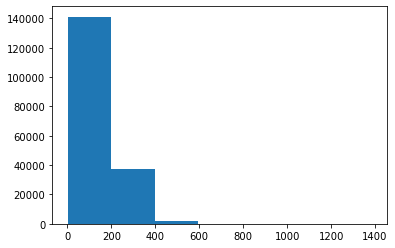

In [68]:
plt.hist(char_lens, bins=7)

In [69]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [70]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [71]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer"
                                   )

char_vectorizer.adapt(train_chars)

In [72]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [73]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
i n   t h e   c o n c u r r e n t   c h e m o r a d i o t h e r a p y   g r o u p   ,   t h e   o v e r a l l   r e s p o n s e   r a t e   w a s   @   %   (   @ / @   )   ,   t u m o r   c o n t r o l   r a t e   w a s   @   %   a n d   a   p a t h o l o g i c a l   c o m p l e t e   r e s p o n s e   w a s   a c h i e v e d   i n   @   %   (   @ / @   )   .

Length of chars: 145

Vectorized chars:
[[ 4  6  3 13  2 11  7  6 11 16  8  8  2  6  3 11 13  2 15  7  8  5 10  4
   7  3 13  2  8  5 14 19 18  8  7 16 14  3 13  2  7 21  2  8  5 12 12  8
   2  9 14  7  6  9  2  8  5  3  2 20  5  9  3 16 15  7  8 11  7  6  3  8
   7 12  8  5  3  2 20  5  9  5  6 10  5 14  5  3 13  7 12  7 18  4 11  5
  12 11  7 15 14 12  2  3  2  8  2  9 14  7  6  9  2 20  5  9  5 11 13  4
   2 21  2 10  4  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [74]:
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                             output_dim=25,
                              mask_zero=False,
                              name="char_embed"
                             )


# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
i n   t h e   c o n c u r r e n t   c h e m o r a d i o t h e r a p y   g r o u p   ,   t h e   o v e r a l l   r e s p o n s e   r a t e   w a s   @   %   (   @ / @   )   ,   t u m o r   c o n t r o l   r a t e   w a s   @   %   a n d   a   p a t h o l o g i c a l   c o m p l e t e   r e s p o n s e   w a s   a c h i e v e d   i n   @   %   (   @ / @   )   .

Embedded chars (after vectorization and embedding):
[[[ 0.04262629  0.02349417 -0.04392989 ...  0.03827174 -0.02784822
   -0.02209899]
  [-0.02563715  0.03527446 -0.00010487 ...  0.02499387  0.00558852
   -0.03972658]
  [-0.01584969 -0.00284425 -0.00394547 ...  0.02918797  0.00757493
    0.00877611]
  ...
  [ 0.0161504   0.00821089  0.00847595 ...  0.01383175 -0.032208
    0.00835745]
  [ 0.0161504   0.00821089  0.00847595 ...  0.01383175 -0.032208
    0.00835745]
  [ 0.0161504   0.00821089  0.00847595 ...  0.01383175 -0.032208
    0.00835745]]]

Character embedding shape: (1, 

In [75]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [76]:
model_3.summary()


Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1700      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [77]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [78]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 6ms/step - loss: 1.2588 - accuracy: 0.4941 - val_loss: 1.0222 - val_accuracy: 0.5991
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9909 - accuracy: 0.6020 - val_loss: 0.9309 - val_accuracy: 0.6360
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9163 - accuracy: 0.6390 - val_loss: 0.8601 - val_accuracy: 0.6659


In [79]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.8776 - accuracy: 0.6584


[0.8776273131370544, 0.6583807468414307]

In [80]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.83807758506553,
 'precision': 0.6505943799089137,
 'recall': 0.6583807758506554,
 'f1': 0.6471731050895714}

In [92]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [93]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

In [94]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [95]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [96]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [97]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 28s 46ms/step - loss: 0.9622 - accuracy: 0.6147 - val_loss: 0.7797 - val_accuracy: 0.6978
Epoch 2/3
562/562 [==============================] - 23s 41ms/step - loss: 0.7859 - accuracy: 0.6943 - val_loss: 0.7073 - val_accuracy: 0.7320
Epoch 3/3
562/562 [==============================] - 21s 38ms/step - loss: 0.7618 - accuracy: 0.7084 - val_loss: 0.6855 - val_accuracy: 0.7374


In [98]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 31s 33ms/step - loss: 0.6900 - accuracy: 0.7353


[0.6899733543395996, 0.73533695936203]

In [99]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.53369522044221,
 'precision': 0.7380634149433533,
 'recall': 0.7353369522044221,
 'f1': 0.733607453844797}